# Processing data for modelling

## - Stock price

In [1]:
import pandas as pd
# test with feature_engineering.py
prices = pd.read_csv('data/train_files/stock_prices.csv', parse_dates=[1])
print(prices.shape)
prices.head(2)


(2332531, 12)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


In [2]:

from feature_engineering import fill_and_drop_na_values

fill_prices = fill_and_drop_na_values(prices)
print(fill_prices.shape)
fill_prices.head(2)


100%|██████████| 2000/2000 [06:04<00:00,  5.49it/s]


(2332531, 12)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.00073
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.00292


In [4]:
from datetime import datetime
#fill_prices['Date'] = fill_prices['Date'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
#fill_prices['Date'] = pd.to_datetime(fill_prices['Date'])

In [6]:
from feature_engineering import adjust_price

adjusted_price = adjust_price(fill_prices)
print(adjusted_price.shape)
adjusted_price.head(2)

100%|██████████| 2000/2000 [19:32<00:00,  1.71it/s]


(2332531, 18)


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target
1483,20170104_8194,2017-01-04,8194,3325.0,3390.0,3300.0,3380.0,36100,1.0,NaN,False,-0.002963,3325.0,3390.0,3300.0,3380.0,36100.0,-0.002963
3348,20170105_8194,2017-01-05,8194,3395.0,3420.0,3360.0,3375.0,19400,1.0,NaN,False,-0.020802,3395.0,3420.0,3360.0,3375.0,19400.0,-0.020802


In [7]:
#adjusted_price['Date'] = pd.to_datetime(adjusted_price['Date'])

## - Financials

In [8]:
#from feature_engineering import fill_finances

financial = financial = pd.read_csv('data/train_files/financials.csv',parse_dates=[2])
financial.head(2)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0


In [36]:
#financial = financial.query('TypeOfDocument != "ForecastRevision" or TypeOfDocument != "ForecastRevision_REIT"')
financial = financial.query('TypeOfDocument != ["ForecastRevision", "ForecastRevision_REIT"]')

In [9]:
from feature_engineering import fill_finances_knn



filled_finances = fill_finances_knn(financial, prices)
filled_finances.head()
filled_finances.shape

100%|██████████| 2000/2000 [00:07<00:00, 284.00it/s]


(48142, 7)

In [17]:
filled_finances.SecuritiesCode.nunique()

2000

In [24]:
# ffill and drop 

def new_features_financial(filled_finances):
    sec_codes = filled_finances.SecuritiesCode.unique()

    filled_financial_feat = pd.DataFrame(columns=filled_finances.columns)

    for i in tqdm(sec_codes):
        # select a security code
        aktie = filled_finances.query('SecuritiesCode == @i')
        aktie.sort_values('Date')
        # create new features:
        aktie['margin'] = aktie['Profit'] / aktie['NetSales'] * 100
        aktie['profit_ttm'] = aktie['Profit'].shift(3) + aktie['Profit'].shift(2) + aktie['Profit'].shift(1) + aktie['Profit']
        aktie['rev_ttm'] = aktie['NetSales'].shift(3) + aktie['NetSales'].shift(2) + aktie['NetSales'].shift(1) + aktie['NetSales']
        aktie['win_quarter_growth'] = (aktie['Profit'] - aktie['Profit'].shift(1)) / aktie['Profit'].shift(1) * 100
        aktie['rev_quarter_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(1)) / aktie['NetSales'].shift(1) * 100
        aktie['win_yoy_growth'] = (aktie['Profit'] - aktie['Profit'].shift(4)) / aktie['Profit'].shift(4) * 100
        aktie['rev_yoy_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(4)) / aktie['NetSales'].shift(4) * 100
        aktie['win_ttm_growth'] = (aktie['profit_ttm'] - aktie['profit_ttm'].shift(1)) / aktie['profit_ttm'].shift(1) * 100
        aktie['rev_ttm_growth'] = (aktie['rev_ttm'] - aktie['rev_ttm'].shift(1)) / aktie['rev_ttm'].shift(1) * 100

        # fill
        aktie = aktie.ffill()
        aktie = aktie.dropna(axis=0)

        filled_financial_feat  = pd.concat([filled_financial_feat , aktie])
    
    return filled_financial_feat

In [25]:
filled_financial_features = new_features_financial(filled_finances)

100%|██████████| 2000/2000 [01:26<00:00, 23.05it/s]


In [20]:
#filled_financial_features.head()

,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales,margin,profit_ttm,rev_ttm,win_quarter_growth,rev_quarter_growth,win_yoy_growth,rev_yoy_growth,win_ttm_growth,rev_ttm_growth
4,2017-11-06 00:00:00,6.0,11.0,2017.0,1301.0,1633000000.0,120458000000.0,1.355659,6.442000e+09,5.343210e+11,116.578249,111.909788,-33.319722,-33.069593,-11.242767,-10.022430
5,2018-02-09 00:00:00,9.0,2.0,2018.0,1301.0,2784000000.0,198323000000.0,1.403771,7.593000e+09,6.121860e+11,70.483772,64.640788,70.483772,64.640788,17.867122,14.572701
6,2018-02-09 00:00:00,9.0,2.0,2018.0,1301.0,1633000000.0,120458000000.0,1.355659,6.804000e+09,4.960830e+11,-41.343391,-39.261709,-32.576383,-49.079519,-10.391150,-18.965314
7,2018-05-10 00:00:00,10.0,5.0,2018.0,1301.0,3211000000.0,254783000000.0,1.260288,9.261000e+09,6.940220e+11,96.631966,111.511896,325.862069,348.214411,36.111111,39.900380
8,2018-08-03 00:00:00,3.0,8.0,2018.0,1301.0,555000000.0,57957000000.0,0.957607,8.183000e+09,6.315210e+11,-82.715665,-77.252407,-66.013472,-51.886135,-11.640212,-9.005622


In [26]:
filled_financial_features.head()

,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales,margin,profit_ttm,rev_ttm,win_quarter_growth,rev_quarter_growth,win_yoy_growth,rev_yoy_growth,win_ttm_growth,rev_ttm_growth
4,2017-11-06 00:00:00,6.0,11.0,2017.0,1301.0,1633000000.0,120458000000.0,1.355659,6.442000e+09,5.343210e+11,116.578249,111.909788,-33.319722,-33.069593,-11.242767,-10.022430
5,2018-02-09 00:00:00,9.0,2.0,2018.0,1301.0,2784000000.0,198323000000.0,1.403771,7.593000e+09,6.121860e+11,70.483772,64.640788,70.483772,64.640788,17.867122,14.572701
6,2018-02-09 00:00:00,9.0,2.0,2018.0,1301.0,1633000000.0,120458000000.0,1.355659,6.804000e+09,4.960830e+11,-41.343391,-39.261709,-32.576383,-49.079519,-10.391150,-18.965314
7,2018-05-10 00:00:00,10.0,5.0,2018.0,1301.0,3211000000.0,254783000000.0,1.260288,9.261000e+09,6.940220e+11,96.631966,111.511896,325.862069,348.214411,36.111111,39.900380
8,2018-08-03 00:00:00,3.0,8.0,2018.0,1301.0,555000000.0,57957000000.0,0.957607,8.183000e+09,6.315210e+11,-82.715665,-77.252407,-66.013472,-51.886135,-11.640212,-9.005622


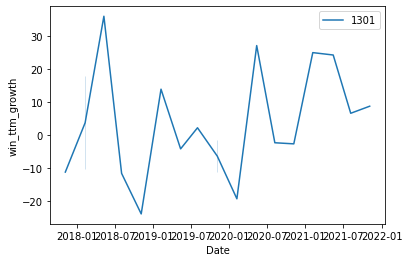

In [23]:
from functions import plot_stock
code = 1301

plot_stock(filled_financial_features, code,'win_ttm_growth' )

<AxesSubplot:xlabel='Date', ylabel='win_ttm_growth'>

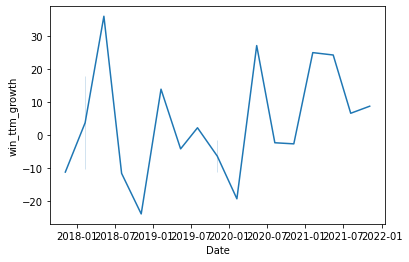

In [22]:
import seaborn as sns
sns.lineplot(filled_financial_features.query('SecuritiesCode == 1301').Date, filled_financial_features.query('SecuritiesCode == 1301').win_ttm_growth)

In [ ]:
stocks = pd.DataFrame(columns=fin_and_prices.columns)
for i in tqdm(prices.SecuritiesCode.unique()):
    # getting financial query for spcific securitiescode
    aktie = df_pred.query('SecuritiesCode == @i')
    # feature engineering
    aktie['margin'] = aktie['Profit'] / aktie['NetSales'] * 100
    aktie['profit_ttm'] = aktie['Profit'].shift(3) + aktie['Profit'].shift(2) + aktie['Profit'].shift(1) + aktie['Profit']
    aktie['rev_ttm'] = aktie['NetSales'].shift(3) + aktie['NetSales'].shift(2) + aktie['NetSales'].shift(1) + aktie['NetSales']
    aktie['win_quarter_growth'] = (aktie['Profit'] - aktie['Profit'].shift(1)) / aktie['Profit'].shift(1) * 100
    aktie['rev_quarter_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(1)) / aktie['NetSales'].shift(1) * 100
    aktie['win_yoy_growth'] = (aktie['Profit'] - aktie['Profit'].shift(4)) / aktie['Profit'].shift(4) * 100
    aktie['rev_yoy_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(4)) / aktie['NetSales'].shift(4) * 100
    aktie['win_ttm_growth'] = (aktie['profit_ttm'] - aktie['profit_ttm'].shift(1)) / aktie['profit_ttm'].shift(1) * 100
    aktie['rev_ttm_growth'] = (aktie['rev_ttm'] - aktie['rev_ttm'].shift(1)) / aktie['rev_ttm'].shift(1) * 100
    aktie['RSI'] =
    # forward fill and drop for financial query
    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)
    # merging financial query and price query of securitiescode
    aktie = pd.merge(prices.query('SecuritiesCode == @i'), aktie, how='left', on=['Date', 'SecuritiesCode'])
    # doing forward fill and drop on combined query
    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)
    # adding combined query of securitiescode to final dataframe
    stocks = pd.concat([stocks, aktie])

## - financials + price

In [11]:
# concat financials and price
price_financial = pd.merge(adjusted_price, filled_finances, how='left', on=['SecuritiesCode', 'Date'])

In [12]:
price_financial.shape

(2335601, 23)

In [13]:
from tqdm import tqdm

In [14]:
# ffill and drop 


sec_codes = price_financial.SecuritiesCode.unique()

price_financial_fill = pd.DataFrame(columns=price_financial.columns)

for i in tqdm(sec_codes):

    current = price_financial.query('SecuritiesCode == @i')
    current = current.ffill()
    current = current.dropna(axis=0)

    price_financial_fill  = pd.concat([price_financial_fill , current])

100%|██████████| 2000/2000 [30:41<00:00,  1.09it/s] 


In [ ]:
stocks = pd.DataFrame(columns=fin_and_prices.columns)
for i in tqdm(prices.SecuritiesCode.unique()):
    # getting financial query for spcific securitiescode
    aktie = df_pred.query('SecuritiesCode == @i')
    # feature engineering
    aktie['margin'] = aktie['Profit'] / aktie['NetSales'] * 100
    aktie['profit_ttm'] = aktie['Profit'].shift(3) + aktie['Profit'].shift(2) + aktie['Profit'].shift(1) + aktie['Profit']
    aktie['rev_ttm'] = aktie['NetSales'].shift(3) + aktie['NetSales'].shift(2) + aktie['NetSales'].shift(1) + aktie['NetSales']
    aktie['win_quarter_growth'] = (aktie['Profit'] - aktie['Profit'].shift(1)) / aktie['Profit'].shift(1) * 100
    aktie['rev_quarter_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(1)) / aktie['NetSales'].shift(1) * 100
    aktie['win_yoy_growth'] = (aktie['Profit'] - aktie['Profit'].shift(4)) / aktie['Profit'].shift(4) * 100
    aktie['rev_yoy_growth'] = (aktie['NetSales'] - aktie['NetSales'].shift(4)) / aktie['NetSales'].shift(4) * 100
    aktie['win_ttm_growth'] = (aktie['profit_ttm'] - aktie['profit_ttm'].shift(1)) / aktie['profit_ttm'].shift(1) * 100
    aktie['rev_ttm_growth'] = (aktie['rev_ttm'] - aktie['rev_ttm'].shift(1)) / aktie['rev_ttm'].shift(1) * 100
    aktie['RSI'] =
    # forward fill and drop for financial query
    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)
    # merging financial query and price query of securitiescode
    aktie = pd.merge(prices.query('SecuritiesCode == @i'), aktie, how='left', on=['Date', 'SecuritiesCode'])
    # doing forward fill and drop on combined query
    aktie = aktie.ffill()
    aktie = aktie.dropna(axis=0)
    # adding combined query of securitiescode to final dataframe
    stocks = pd.concat([stocks, aktie])

In [15]:
# new features
#price_financial_fill.drop_duplicates(inplace=True)
price_financial_fill.shape

(2205125, 23)

In [16]:
# save dataframe to csv
price_financial_fill.to_csv('data/current.csv')

TODOS: 

In [ ]:
# TODO Drop expectedDividend?
# TODO encode flag